### Regressions

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

import warnings
import os

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV, KFold

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.font_manager import FontProperties
from matplotlib.gridspec import GridSpec

import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
warnings.filterwarnings("ignore")
os.chdir("C:\\Users\\joaos\\Documents\\GitHub\\pred_se_ml\data")

### Importing the data

In [5]:
# Importing the data
df = pd.read_csv("pred_se_ml.csv")

print(df.shape)

df.head()

(2420, 26)


,country,year,fdi,property_time,cost_procedures,business_time,business_procedure,tribute_time,governement_spending,exchange,inflation,gdp_pc,unemployment,democ,tax_burden,diversity,quality,se_medina,democ_closed_anocracy,democ_democracy,democ_full_democracy,democ_interregnum,democ_interruption,democ_open_anocracy,democ_transition,lgdp_pc
0,angola,1995,8.529489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1825.495149,398.120223,NaN,transition,61.6,6.002369,0.37,52.47,0,0,0,0,0,0,1,5.986754
1,angola,1996,2.762770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4800.531644,454.375004,NaN,transition,54.6,6.048760,0.40,46.30,0,0,0,0,0,0,1,6.118923
2,angola,1997,5.363360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.453022,516.127849,NaN,autocracy,52.6,5.991146,0.35,50.48,0,0,0,0,0,0,0,6.246355
3,angola,1998,17.121191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.359348,423.403332,NaN,autocracy,59.1,5.882152,0.34,49.21,0,0,0,0,0,0,0,6.048325
4,angola,1999,40.167251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,557.501113,387.689415,NaN,autocracy,47.9,5.903543,0.34,48.64,0,0,0,0,0,0,0,5.960205


In [7]:
# Missing data by column (%)
df.isnull().mean().sort_values(ascending=False).head(10)

tribute_time            0.536777
property_time           0.495868
cost_procedures         0.455372
business_time           0.455372
business_procedure      0.455372
unemployment            0.335950
governement_spending    0.078926
exchange                0.070661
tax_burden              0.046694
quality                 0.011570
dtype: float64

In [8]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                2420 non-null   object 
 1   year                   2420 non-null   int64  
 2   fdi                    2405 non-null   float64
 3   property_time          1220 non-null   float64
 4   cost_procedures        1318 non-null   float64
 5   business_time          1318 non-null   float64
 6   business_procedure     1318 non-null   float64
 7   tribute_time           1121 non-null   float64
 8   governement_spending   2229 non-null   float64
 9   exchange               2249 non-null   float64
 10  inflation              2402 non-null   float64
 11  gdp_pc                 2415 non-null   float64
 12  unemployment           1607 non-null   float64
 13  democ                  2420 non-null   object 
 14  tax_burden             2307 non-null   float64
 15  dive

There is already dummy columns regarding democracy, hence, the democ column will be dropped

In [9]:
df = df.drop('democ', axis=1)

### Dealing with missing data

There is a lot of missing data, especially in relation to the tribute_time, however, if we limit the year range from 2004 to 2014, the proportion of missing data will decrease

In [10]:
df = df[(df['year']>=2004) & (df['year'] <= 2014)]

In [11]:
# Proportion of missing data by country in the column 'unemployment' since it's the variable with the biggest proportion of missing data
missing_by_country = df.groupby('country')['unemployment'].apply(lambda x: x.isnull().sum() / x.count()).sort_values(ascending=False)
#print(missing_by_country)

# Collecting the names of countries that have a proportion of missing data in the unemployment column above 5%
countries = missing_by_country[missing_by_country > 5].index.tolist()
#countries

# Removing these countries
df = df[~df['country'].isin(countries)]

In [12]:
# Replacing missing values with the average for each country for each attribute
mean_by_country = df.groupby('country').transform('mean')
df.fillna(mean_by_country, inplace=True)

After the imputation, 'government spending' and 'exchange' still having missing values, this happens because some countries have the 'inf' as observations and not a usual NaN


In [13]:
# This is seen with the follow code for governement_spending and after for exchange (just change governement_spending by exchange to see all the countries)
missing_by_country = df.groupby('country')['governement_spending'].apply(lambda x: x.isnull().sum() / x.count()).sort_values(ascending=False)
#print(missing_by_country)

In [14]:
# Droping these countries
countries_to_drop = ['malawi', 'trinidad_and_tobago', 'liberia', 'yemen', "cote_d'ivoire", "nigeria"]
df = df[~df['country'].isin(countries_to_drop)]

In [15]:
df.head()

,country,year,fdi,property_time,cost_procedures,business_time,business_procedure,tribute_time,governement_spending,exchange,inflation,gdp_pc,unemployment,tax_burden,diversity,quality,se_medina,democ_closed_anocracy,democ_democracy,democ_full_democracy,democ_interregnum,democ_interruption,democ_open_anocracy,democ_transition,lgdp_pc
9,angola,2004,9.329239,335.0,910.0,83.0,12.0,289.0,14.312063,103.579947,33.443595,1254.696126,23.6430,84.916689,6.330621,0.40,46.81,1,0,0,0,0,0,0,7.134649
10,angola,2005,-3.526657,335.0,653.8,83.0,12.0,284.0,16.029037,106.590962,42.374249,1900.723816,12.6408,84.916689,6.245515,0.42,43.84,1,0,0,0,0,0,0,7.549990
11,angola,2006,-0.072001,335.0,498.2,83.0,12.0,284.0,15.341722,94.625159,17.115665,2597.963585,12.6408,84.900000,6.295336,0.40,41.23,1,0,0,0,0,0,0,7.862483
12,angola,2007,-1.368762,335.0,343.7,83.0,12.0,284.0,15.536935,108.060068,4.308432,3121.348735,12.6408,85.000000,6.211946,0.45,37.13,1,0,0,0,0,0,0,8.046020
13,angola,2008,1.896314,335.0,196.8,68.0,8.0,284.0,16.814612,121.364708,19.365774,4081.717497,12.6408,85.175100,6.315526,0.47,35.26,1,0,0,0,0,0,0,8.314273


In [17]:
# No more missing values
df.isnull().sum().sort_values(ascending=False).head(10)

country                  0
tax_burden               0
democ_transition         0
democ_open_anocracy      0
democ_interruption       0
democ_interregnum        0
democ_full_democracy     0
democ_democracy          0
democ_closed_anocracy    0
se_medina                0
dtype: int64

In [18]:
# Droping columns that will not be used
df = df.drop(['country', 'year'], axis=1)

In [19]:
# Renaming the columns for better future visualization
rename_dictionary = {'se_medina':'Shadow Economy',
                        'lgdp_pc': 'Log. GDP Per Capita', 
                         'democ_transition': 'Dem. Transition', 
                         'democ_interruption': 'Dem. Interruption',
                        'democ_interregnum':'Dem. Interregnum',
                        'democ_full_democracy': 'Dem. Full',
                        'democ_democracy':'Democracy',
                        'democ_autocracy':'Autocracy',
                        'democ_closed_anocracy':'Closed Anocracy',
                        'democ_open_anocracy': 'Open Anocracy',
                        'quality':'Quality',
                        'diversity':'Diversity',
                        'tax_burden':'Tax Burden',
                        'unemployment':'Unemployment',
                        'inflation':'Inflation',
                        'exchange':'Exchange',
                        'governement_spending':'Government Spending',
                         'tribute_time':'Tribute Time',
                        'business_procedure':'Business Procedure',
                        'business_time':'Business Time',
                        'cost_procedures':'Cost Procedures',
                        'property_time':'Property Time',
                        'fdi':'FDI'}

df = df.rename(columns=rename_dictionary)

In [20]:
# Changing the order
new_order = ['Shadow Economy', 'FDI', 'Property Time', 'Cost Procedures', 'Business Time', 'Business Procedure',
               'Tribute Time', 'Government Spending', 'Exchange', 'Inflation', 'Unemployment', 'Tax Burden', 
               'Diversity', 'Quality', 'Closed Anocracy', 'Democracy', 'Dem. Full', 'Dem. Interregnum', 
               'Dem. Interruption', 'Open Anocracy', 'Dem. Transition', 'Log. GDP Per Capita']

df = df.reindex(columns=new_order)

### Spliting between train and test

In [21]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=0)

### Data padronization

##### First the training data

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_set.drop(labels=['Shadow Economy'], axis=1),
    train_set['Shadow Economy'],
    test_size=0.2,
    random_state=0
)

In [23]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

##### After, the testing data

In [24]:
X_test = test_set.drop('Shadow Economy', axis=1)
y_test = test_set['Shadow Economy']

X_test_scaled = scaler.transform(X_test)

X_test_scaled

array([[5.48358593e-02, 9.86937591e-02, 1.50844730e-02, ...,
        1.00000000e+00, 0.00000000e+00, 5.44614959e-01],
       [5.76425349e-02, 1.01596517e-02, 5.29632609e-03, ...,
        0.00000000e+00, 0.00000000e+00, 6.97405026e-01],
       [3.95217773e-02, 6.09579100e-02, 6.30195763e-03, ...,
        0.00000000e+00, 0.00000000e+00, 3.22696045e-01],
       ...,
       [2.79046115e-02, 3.19303338e-02, 2.01126307e-04, ...,
        0.00000000e+00, 0.00000000e+00, 6.17652554e-01],
       [3.48678199e-02, 5.66037736e-01, 8.04505229e-03, ...,
        0.00000000e+00, 0.00000000e+00, 7.24268686e-01],
       [2.91278719e-02, 8.70827286e-03, 4.02252615e-04, ...,
        0.00000000e+00, 0.00000000e+00, 9.01553830e-01]])

### Regressions

#### Linear Regression

In [45]:
from sklearn.linear_model import LinearRegression

# Params set
linear_param_grid = {
    'fit_intercept': [True, False],
    'copy_X':[True, False]
}

# Create a linear regression model
linear_model = LinearRegression()

# Perform Grid Search with cross-validation
linear_grid_search = GridSearchCV(linear_model, 
                                  linear_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=5,
                                  verbose=3,
                                  n_jobs=-1)

# Fitting the model
linear_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("\nBest Parameters: ", linear_grid_search.best_params_)

# Get the best model
linear_best_model = linear_grid_search.best_estimator_

# Predictions and evaluations on training set
y_train_pred = linear_grid_search.predict(X_train_scaled)
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
print(f'\nMean Absolute Percentage Error (MAPE) on training set: {mape_train:.2f}%')

# Predictions and evaluations on validation set
y_pred = linear_grid_search.predict(X_valid_scaled)
mape = np.mean(np.abs((y_valid - y_pred) / y_valid)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on validation set: {mape:.2f}%')

# Predictions and evaluations on test set
y_test_pred = linear_grid_search.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')

# Access cross-validation results
cv_results = linear_grid_search.cv_results_

# Print mean and std for each fold
for fold_idx in range(linear_grid_search.cv):
    mean_score = -cv_results[f"split{fold_idx}_test_score"].mean() * 100  # Convert to percentage
    std_score = cv_results[f"split{fold_idx}_test_score"].std() * 100  # Convert to percentage

    print(f"Fold {fold_idx + 1}: Mean Score = {mean_score:.2f}%, Std = {std_score:.2f}%")

# Calculate and print global mean and std
global_mean_score = -cv_results['mean_test_score'].mean() * 100  # Convert to percentage
global_std_score = cv_results['mean_test_score'].std() * 100  # Convert to percentage

print(f"\nOverall Mean Score = {global_mean_score:.2f}%, Overall Std = {global_std_score:.2f}%")


Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Parameters:  {'copy_X': True, 'fit_intercept': True}

Mean Absolute Percentage Error (MAPE) on training set: 24.43%
Mean Absolute Percentage Error (MAPE) on validation set: 24.53%
Mean Absolute Percentage Error (MAPE) on test set: 23.60% 

Fold 1: Mean Score = 25.58%, Std = 1.02%
Fold 2: Mean Score = 29.77%, Std = 2.94%
Fold 3: Mean Score = 24.95%, Std = 0.38%
Fold 4: Mean Score = 24.21%, Std = 1.08%
Fold 5: Mean Score = 28.54%, Std = 1.75%

Overall Mean Score = 26.61%, Overall Std = 1.43%


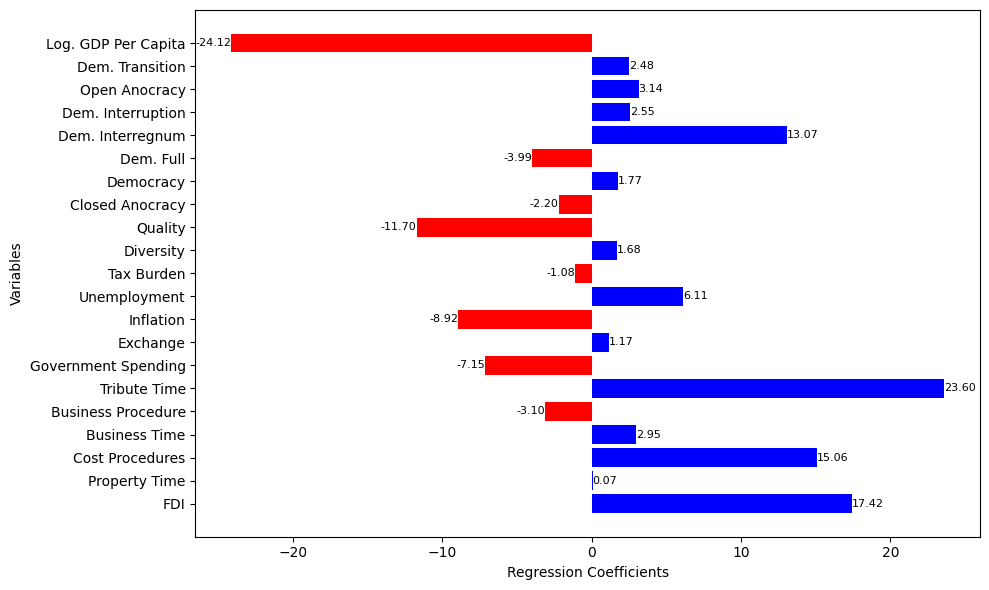

In [26]:
coeficientes = linear_best_model.coef_
colors = ['red' if coef < 0 else 'blue' for coef in coeficientes]
plt.figure(figsize=(10, 6))


variables_names = X_train.columns.tolist()

plt.barh(variables_names, coeficientes, color=colors)
plt.xlabel('Regression Coefficients')
plt.ylabel('Variables')


for i, coef in enumerate(coeficientes):
    if coef < 0:
        plt.text(coef, i, f'{coef:.2f}', ha='right', va='center', color='black', fontsize=8)
    else:
        plt.text(coef, i, f'{coef:.2f}', ha='left', va='center', color='black', fontsize=8)
  
plt.tight_layout()

        
plt.show()

### Lasso

In [49]:
from sklearn.linear_model import Lasso

lasso_param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'alpha': [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1.0, 10.0, 100.0],  
    'max_iter': [1000, 2000, 3000, 5000]  
}

# Create a lasso model
lasso_model = Lasso(random_state=0)

# Perform Grid Search with cross-validation
lasso_grid_search = GridSearchCV(lasso_model, 
                                  lasso_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=5,
                                  verbose=3,
                                  n_jobs=-1)

# Fitting the model
lasso_grid_search.fit(X_train_scaled, y_train)

# Get the best model
lasso_best_model = lasso_grid_search.best_estimator_

# Predictions and evaluations on training set
y_train_pred = lasso_best_model.predict(X_train_scaled)
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
print(f'\nMean Absolute Percentage Error (MAPE) on training set: {mape_train:.2f}%')

# Predictions and evaluations on validation set
y_pred = lasso_best_model.predict(X_valid_scaled)
mape = np.mean(np.abs((y_valid - y_pred) / y_valid)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on validation set: {mape:.2f}%')

# Predictions and evaluations on test set
y_test_pred = lasso_best_model.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')

# Access cross-validation results
cv_results = lasso_grid_search.cv_results_

# Print mean and std for each fold
for fold_idx in range(lasso_grid_search.cv):
    mean_score = -cv_results[f"split{fold_idx}_test_score"].mean() * 100  # Convert to percentage
    std_score = cv_results[f"split{fold_idx}_test_score"].std() * 100  # Convert to percentage

    print(f"Fold {fold_idx + 1}: Mean Score = {mean_score:.2f}%, Std = {std_score:.2f}%")

# Calculate and print global mean and std
global_mean_score = -cv_results['mean_test_score'].mean() * 100  # Convert to percentage
global_std_score = cv_results['mean_test_score'].std() * 100  # Convert to percentage

print(f"\nOverall Mean Score = {global_mean_score:.2f}%, Overall Std = {global_std_score:.2f}%")

Fitting 5 folds for each of 128 candidates, totalling 640 fits



Mean Absolute Percentage Error (MAPE) on training set: 24.52%
Mean Absolute Percentage Error (MAPE) on validation set: 24.81%
Mean Absolute Percentage Error (MAPE) on test set: 23.63% 

Fold 1: Mean Score = 37.64%, Std = 19.79%
Fold 2: Mean Score = 39.52%, Std = 17.80%
Fold 3: Mean Score = 36.00%, Std = 19.50%
Fold 4: Mean Score = 35.34%, Std = 19.57%
Fold 5: Mean Score = 39.61%, Std = 18.65%

Overall Mean Score = 37.62%, Overall Std = 19.01%


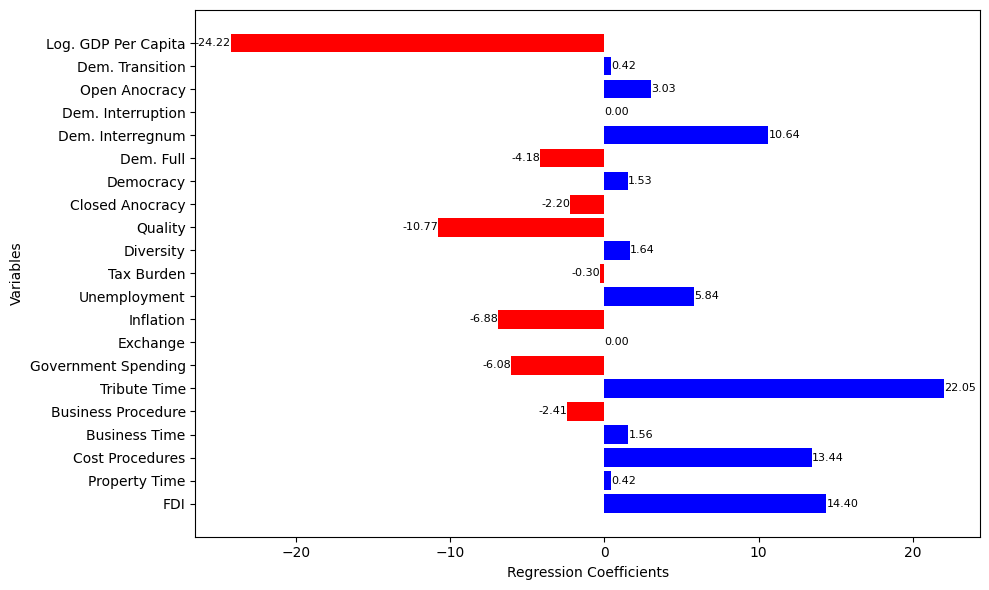

In [50]:
lasso_coeficients = lasso_best_model.coef_
colors = ['red' if coef < 0 else 'blue' for coef in lasso_coeficients]
plt.figure(figsize=(10, 6))


variables_names = X_train.columns.tolist()

plt.barh(variables_names, lasso_coeficients, color=colors)
plt.xlabel('Regression Coefficients')
plt.ylabel('Variables')


for i, coef in enumerate(lasso_coeficients):
    if coef < 0:
        plt.text(coef, i, f'{coef:.2f}', ha='right', va='center', color='black', fontsize=8)
    else:
        plt.text(coef, i, f'{coef:.2f}', ha='left', va='center', color='black', fontsize=8)
  
plt.tight_layout()

        
plt.show()

### Ridge

In [51]:
from sklearn.linear_model import Ridge

ridge_param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'alpha': [0.1, 0.5, 1.0, 1.5],  
    'max_iter': [1000, 2000, 3000]  
}

# Create a lasso model
ridge_model = Ridge()

# Perform Grid Search with cross-validation
ridge_grid_search = GridSearchCV(ridge_model, 
                                  ridge_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=5,
                                  verbose=2,
                                  n_jobs=-1)

# Fitting the model
ridge_grid_search.fit(X_train_scaled, y_train)

# Get the best model
ridge_best_model = ridge_grid_search.best_estimator_

# Predictions and evaluations on training set
y_train_pred = ridge_best_model.predict(X_train_scaled)
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
print(f'\nMean Absolute Percentage Error (MAPE) on training set: {mape_train:.2f}%')

# Predictions and evaluations on validation set
y_pred = ridge_best_model.predict(X_valid_scaled)
mape = np.mean(np.abs((y_valid - y_pred) / y_valid)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on validation set: {mape:.2f}%')

# Predictions and evaluations on test set
y_test_pred = ridge_best_model.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')

# Access cross-validation results
cv_results = ridge_grid_search.cv_results_

# Print mean and std for each fold
for fold_idx in range(ridge_grid_search.cv):
    mean_score = -cv_results[f"split{fold_idx}_test_score"].mean() * 100  # Convert to percentage
    std_score = cv_results[f"split{fold_idx}_test_score"].std() * 100  # Convert to percentage

    print(f"Fold {fold_idx + 1}: Mean Score = {mean_score:.2f}%, Std = {std_score:.2f}%")

# Calculate and print global mean and std
global_mean_score = -cv_results['mean_test_score'].mean() * 100  # Convert to percentage
global_std_score = cv_results['mean_test_score'].std() * 100  # Convert to percentage

print(f"\nOverall Mean Score = {global_mean_score:.2f}%, Overall Std = {global_std_score:.2f}%")

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Mean Absolute Percentage Error (MAPE) on training set: 24.45%
Mean Absolute Percentage Error (MAPE) on validation set: 24.54%
Mean Absolute Percentage Error (MAPE) on test set: 23.58% 

Fold 1: Mean Score = 25.83%, Std = 1.08%
Fold 2: Mean Score = 29.90%, Std = 3.09%
Fold 3: Mean Score = 25.07%, Std = 0.85%
Fold 4: Mean Score = 24.42%, Std = 1.16%
Fold 5: Mean Score = 28.92%, Std = 1.87%

Overall Mean Score = 26.83%, Overall Std = 1.60%


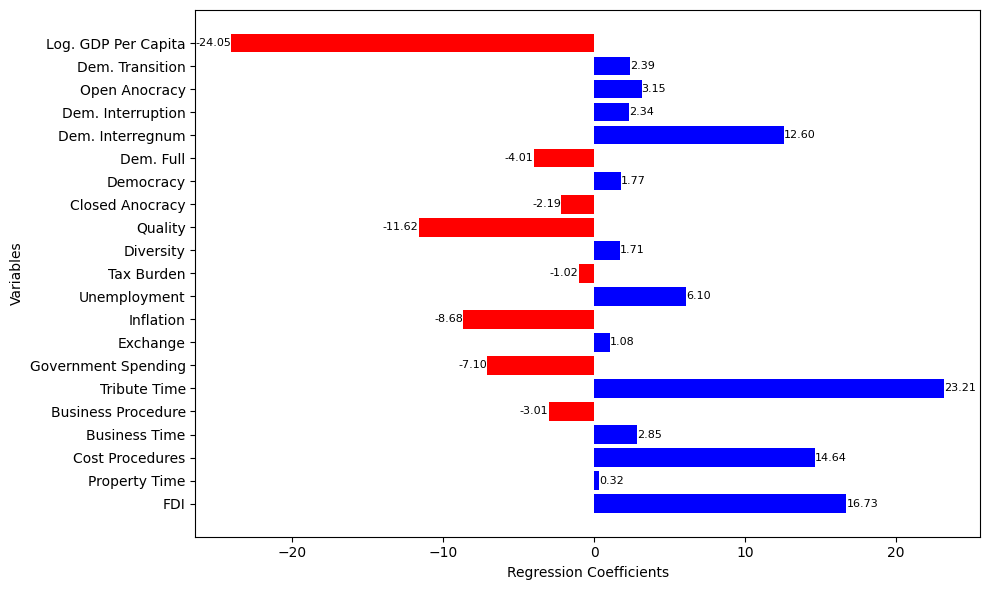

In [52]:
ridge_coeficients = ridge_best_model.coef_
colors = ['red' if coef < 0 else 'blue' for coef in ridge_coeficients]
plt.figure(figsize=(10, 6))


variables_names = X_train.columns.tolist()

plt.barh(variables_names, ridge_coeficients, color=colors)
plt.xlabel('Regression Coefficients')
plt.ylabel('Variables')


for i, coef in enumerate(ridge_coeficients):
    if coef < 0:
        plt.text(coef, i, f'{coef:.2f}', ha='right', va='center', color='black', fontsize=8)
    else:
        plt.text(coef, i, f'{coef:.2f}', ha='left', va='center', color='black', fontsize=8)
  
plt.tight_layout()

        
plt.show()

### ElasticNet

In [54]:
from sklearn.linear_model import ElasticNet

en_param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
              'l1_ratio': [0.25, 0.5, 0.75],
              'fit_intercept': [True, False],
              'max_iter': [1000, 2000, 3000],
              'tol': [1e-4, 1e-3, 1e-2]}

# Create a lasso model
en_model = ElasticNet(random_state=0)

# Perform Grid Search with cross-validation
en_grid_search = GridSearchCV(en_model, 
                                  en_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=5,
                                  verbose=2,
                                  n_jobs=-1)

# Fitting the model
en_grid_search.fit(X_train_scaled, y_train)

# Get the best model
en_best_model = en_grid_search.best_estimator_

# Predictions and evaluations on training set
y_train_pred = en_best_model.predict(X_train_scaled)
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
print(f'\nMean Absolute Percentage Error (MAPE) on training set: {mape_train:.2f}%')

# Predictions and evaluations on validation set
y_pred = en_best_model.predict(X_valid_scaled)
mape = np.mean(np.abs((y_valid - y_pred) / y_valid)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on validation set: {mape:.2f}%')

# Predictions and evaluations on test set
y_test_pred = en_best_model.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')

# Access cross-validation results
cv_results = en_grid_search.cv_results_

# Print mean and std for each fold
for fold_idx in range(en_grid_search.cv):
    mean_score = -cv_results[f"split{fold_idx}_test_score"].mean() * 100  # Convert to percentage
    std_score = cv_results[f"split{fold_idx}_test_score"].std() * 100  # Convert to percentage

    print(f"Fold {fold_idx + 1}: Mean Score = {mean_score:.2f}%, Std = {std_score:.2f}%")

# Calculate and print global mean and std
global_mean_score = -cv_results['mean_test_score'].mean() * 100  # Convert to percentage
global_std_score = cv_results['mean_test_score'].std() * 100  # Convert to percentage

print(f"\nOverall Mean Score = {global_mean_score:.2f}%, Overall Std = {global_std_score:.2f}%")

Fitting 5 folds for each of 270 candidates, totalling 1350 fits



Mean Absolute Percentage Error (MAPE) on training set: 24.48%
Mean Absolute Percentage Error (MAPE) on validation set: 24.58%
Mean Absolute Percentage Error (MAPE) on test set: 23.57% 

Fold 1: Mean Score = 39.29%, Std = 16.16%
Fold 2: Mean Score = 40.10%, Std = 14.17%
Fold 3: Mean Score = 37.11%, Std = 16.26%
Fold 4: Mean Score = 36.33%, Std = 16.14%
Fold 5: Mean Score = 40.63%, Std = 14.84%

Overall Mean Score = 38.69%, Overall Std = 15.45%
